In [1]:
import os
import random
import torch

from torch.utils.data import DataLoader, Subset
from src import DAPSAudioDataset_with_multiple_cropping

# Create class_mapping
audio_dir = "precomputed_spectrograms_aug"
class_1_speakers = ["f1", "f7", "f8", "m3", "m6", "m8"]

class_mapping = {}
for root, dirs, files in os.walk(audio_dir):
    for file in files:
        audio_path = os.path.join(root, file)
        try:
            speaker_prefix = file.split("_")[0]
            if speaker_prefix in class_1_speakers:
                class_mapping[audio_path] = 1
            else:
                class_mapping[audio_path] = 0
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")

print(f"Class mapping created with {len(class_mapping)} items.")

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

full_dataset = DAPSAudioDataset_with_multiple_cropping(
    class_mapping=class_mapping, num_crops=3
)

validation_ids = []
train_test_ids = []

for idx in range(len(full_dataset)):
    path, label = full_dataset.extended_mapping[idx]
    filename = os.path.basename(path)
    filename_without_ext = os.path.splitext(filename)[0]
    if "script1" in filename_without_ext and "aug" not in filename_without_ext:
        validation_ids.append(idx)
    else:
        train_test_ids.append(idx)


validation_dataset = Subset(full_dataset, validation_ids)


def get_train_test_loaders(dataset, test_split=0.2, batch_size=64):
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    split_idx = int(len(indices) * (1 - test_split))
    train_ids = indices[:split_idx]
    test_ids = indices[split_idx:]

    train_loader = DataLoader(
        Subset(dataset, train_ids),
        batch_size=batch_size,
        shuffle=True,
    )
    test_loader = DataLoader(
        Subset(dataset, test_ids),
        batch_size=batch_size,
        shuffle=True,
    )
    return train_loader, test_loader


train_loader, test_loader = get_train_test_loaders(Subset(full_dataset, train_test_ids))

validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

for batch in train_loader:
    inputs, labels = batch
    print(f"Train Inputs shape: {inputs.shape}")
    print(f"Train Labels: {labels}")
    break

for batch in test_loader:
    inputs, labels = batch
    print(f"Test Inputs shape: {inputs.shape}")
    print(f"Test Labels: {labels}")
    break

for batch in validation_loader:
    inputs, labels = batch
    print(f"Validation Inputs shape: {inputs.shape}")
    print(f"Validation Labels: {labels}")
    break

Class mapping created with 2400 items.


c:\Users\cypri\VoiceRecognition\src\pytorch_datasets.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram_tensor = torch.load(spectrogram_path)


Train Inputs shape: torch.Size([64, 1, 64, 64])
Train Labels: tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1])
Test Inputs shape: torch.Size([64, 1, 64, 64])
Test Labels: tensor([1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1])
Validation Inputs shape: torch.Size([16, 1, 64, 64])
Validation Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [2]:
import torch
import multiprocessing

torch.set_num_threads(4)

print("Nombre de cœurs physiques:", multiprocessing.cpu_count())

logical_cores = torch.get_num_threads()
print("Nombre de cœurs logiques (threads disponibles):", logical_cores)

Nombre de cœurs physiques: 8
Nombre de cœurs logiques (threads disponibles): 4


In [3]:
train_loader

In [15]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from src import Net
import json
import os
import matplotlib.pyplot as plt
from src import plot_training_results
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

freq_bins = 64
time_steps = 64


configs = [
    {
        "lr": 0.0001,
        "optimizer": lambda model: optim.SGD(
            model.parameters(), lr=0.0001, momentum=0.9
        ),
    },
    {
        "lr": 0.001,
        "optimizer": lambda model: optim.SGD(
            model.parameters(), lr=0.001, momentum=0.9
        ),
    },
]

num_epochs = 60
batch_size = 70


for config in configs:
    lr = config["lr"]
    optimizer = config["optimizer"]

    model = Net(freq_bins, time_steps).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_instance = optimizer(model)

    optimizer_name = type(optimizer_instance).__name__

    metadata = {
        "model": str(model),
        "freq_bins": freq_bins,
        "time_steps": time_steps,
        "batch_size": batch_size,
        "optimizer": optimizer_name,
        "loss_function": str(criterion),
        "num_epochs": num_epochs,
    }

    timestamp = time.strftime("%S-%M-%H-%d-%m-%Y")
    results_path = f"models_results_against_validation_test/{num_epochs}x{lr}x{optimizer_name}x{len(train_loader.dataset)}_{timestamp}.json"
    os.makedirs(os.path.dirname(results_path), exist_ok=True)

    training_results = {"metadata": metadata, "data": {}}

    
    train_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}, start training with lr={lr}...")

        
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer_instance.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer_instance.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        
        model.eval()
        running_vloss = 0.0

        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                vloss = criterion(outputs, labels)
                running_vloss += vloss.item()

        avg_val_loss = running_vloss / len(validation_loader)
        validation_losses.append(avg_val_loss)

        
        epoch_data = {
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "lr": optimizer_instance.param_groups[0]["lr"],
        }
        training_results["data"][str(epoch + 1)] = epoch_data

        with open(results_path, "w") as f:
            json.dump(training_results, f, indent=4)

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}"
        )

    
    

    
    

    print(f"Results saved in: {results_path}")

Epoch 1/60, start training with lr=0.0001...
Epoch [1/60], Train Loss: 1.3994, Validation Loss: 1.0071
Epoch 2/60, start training with lr=0.0001...


KeyboardInterrupt: 

In [6]:
import json
import matplotlib.pyplot as plt


def plot_validation_results(plot, json_path, label_prefix="", start_epoch=0, title=""):
    """
    Plots the training loss from a JSON file on an existing matplotlib plot.

    Args:
        plot: The matplotlib Axes object to plot on.
        json_path: Path to the JSON file containing training results.
        label_prefix: Prefix for the legend label to distinguish datasets.
        start_epoch: The starting epoch for plotting (default is 0).

    Returns:
        The updated matplotlib Axes object with the new data plotted.
    """
    # Load JSON data
    with open(json_path, "r") as f:
        results = json.load(f)

    # Extract data
    data = results.get("data", {})
    metadata = results.get("metadata", {})

    # Prepare x (epochs) and y (loss) data
    epochs = sorted(int(epoch) for epoch in data.keys())
    validation_losses = [data[str(epoch)]["val_loss"] for epoch in epochs]

    # Filter epochs and losses to start from the specified epoch
    filtered_epochs = [epoch for epoch in epochs if epoch >= start_epoch]
    filtered_validation_losses = [
        data[str(epoch)]["val_loss"] for epoch in filtered_epochs
    ]

    # Extract the learning rate (assuming it's constant or take the first one)
    lr = data[str(epochs[0])]["lr"]

    # Plot the data
    label = f"{label_prefix} (lr={lr})"
    plot.plot(filtered_epochs, filtered_validation_losses, label=label)

    # Add plot details
    plot.set_xlabel("Epochs")
    plot.set_ylabel("Loss")
    plot.legend()
    plot.grid(True)
    if title:
        plot.set_title(title)

    return plot

<Axes: xlabel='Epochs', ylabel='Loss'>

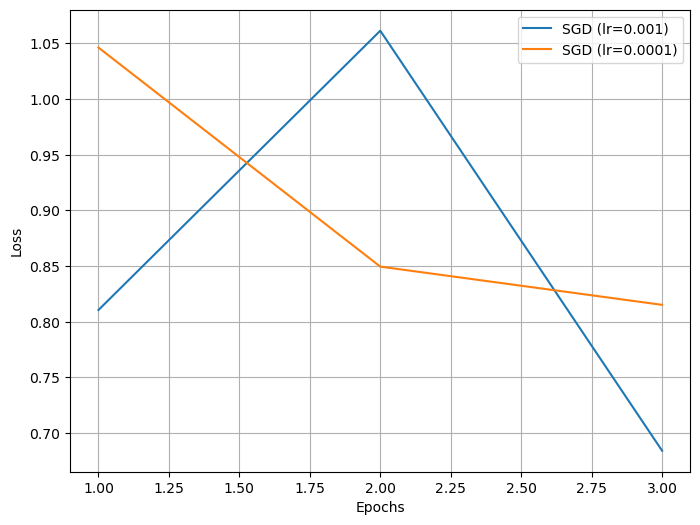

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from src import Net
import json
import os
import matplotlib.pyplot as plt

import time

fig, ax = plt.subplots(figsize=(8, 6))

results_path = (
    "models_results_against_validation_test/"
    + "3x0.001xSGDx5040_09-05-11-19-01-2025.json"
)
plot_validation_results(ax, results_path, label_prefix="SGD",title = "Validation Loss against Epochs")

results_path = (
    "models_results_against_validation_test/"
    + "3x0.0001xSGDx5040_19-59-10-19-01-2025.json"
)
plot_validation_results(ax, results_path, label_prefix="SGD",title = "Validation Loss against Epochs")